## EY Data Science Challenge

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import datetime

from shapely.geometry import Point, Polygon
from shapely.geometry import LineString
from shapely.ops import nearest_points

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn')

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### Load data

In [2]:
df_train = pd.read_csv('data_train.csv', index_col=0)

In [3]:
print('Shape: ', df_train.shape)
df_train.head()

Shape:  (814262, 11)


,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07


### Data Analysis

Statistics

In [4]:
df_train.describe()

,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit
count,256769.000000,256769.000000,270778.000000,8.142620e+05,8.142620e+05,8.142620e+05,8.142620e+05
mean,2.680249,2.279469,2.454799,3.760411e+06,-1.922153e+07,3.760426e+06,-1.922181e+07
std,7.591053,7.118452,7.160578,8.974393e+03,7.632234e+04,8.904451e+03,7.515560e+04
min,-1.000000,-1.000000,-1.000000,3.741027e+06,-1.938291e+07,3.740998e+06,-1.937688e+07
25%,0.000000,-1.000000,0.000000,3.755174e+06,-1.927454e+07,3.755359e+06,-1.927308e+07
50%,0.000000,0.000000,0.000000,3.760071e+06,-1.923020e+07,3.760076e+06,-1.923031e+07
75%,0.500000,0.220000,0.440000,3.767509e+06,-1.916999e+07,3.767455e+06,-1.917193e+07
max,162.000000,162.000000,162.000000,3.777099e+06,-1.904266e+07,3.777055e+06,-1.904666e+07


Missing Values

In [5]:
df_train.isnull().sum()

hash                  0
trajectory_id         0
time_entry            0
time_exit             0
vmax             557493
vmin             557493
vmean            543484
x_entry               0
y_entry               0
x_exit                0
y_exit                0
dtype: int64

Distribuition of number of trajectories per Hash

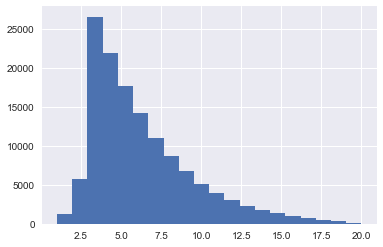

In [6]:
df_train['hash'].value_counts().hist(bins=20)

### Adjust types

In [7]:
df_train['time_entry'] = pd.to_datetime(df_train['time_entry'], format='%H:%M:%S')
df_train['time_exit'] = pd.to_datetime(df_train['time_exit'], format='%H:%M:%S')

df_train['hash'] = df_train['hash'].astype('category')
df_train['hash'] = df_train['hash'].astype('category')

### Verifiy if is in Center City
This information will be used to create the target

In [8]:
x_min = 3750901.5068
x_max = 3770901.5068
y_min = -19268905.6133
y_max = -19208905.6133

In [9]:
condition_x = ((df_train['x_entry'] >= x_min) & (df_train['x_entry'] <= x_max))
condition_y = ((df_train['y_entry'] >= y_min) & (df_train['y_entry'] <= y_max))

df_train['is_center_entry'] = 0
df_train.loc[condition_x & condition_y, 'is_center_entry'] = 1

In [10]:
condition_x = ((df_train['x_exit'] >= x_min) & (df_train['x_exit'] <= x_max))
condition_y = ((df_train['y_exit'] >= y_min) & (df_train['y_exit'] <= y_max))

df_train['is_center_exit'] = 0
df_train.loc[condition_x & condition_y, 'is_center_exit'] = 1

### Create Points

In [11]:
df_train['point_entry'] = df_train.apply(lambda x: Point(x['x_entry'], x['y_entry']), axis=1)
df_train['point_exit'] = df_train.apply(lambda x: Point(x['x_exit'], x['y_exit']), axis=1)

df_train['point_entry'].head()

0    POINT (3751013.769405791 -19093980.64399624)
1    POINT (3743937.189376064 -19322467.54732817)
2    POINT (3744867.820319093 -19293564.92351381)
3    POINT (3744880.065463081 -19292289.76464524)
4     POINT (3744909.008530688 -19285584.9968226)
Name: point_entry, dtype: object

#### An example where the trajectory starts outside of the center and ends in the center city

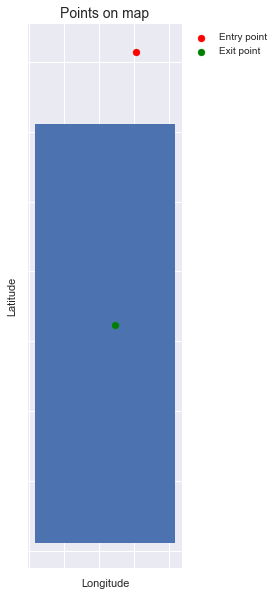

In [12]:
df_train['point_entry'] = df_train.apply(lambda x: Point(x['x_entry'], x['y_entry']), axis=1)
df_train['point_exit'] = df_train.apply(lambda x: Point(x['x_exit'], x['y_exit']), axis=1)

example = df_train[(df_train['is_center_entry'] == 0) & (df_train['is_center_exit'] == 1)].iloc[0]
center = Polygon([(x_min, y_min), (x_min, y_max), (x_max , y_max), (x_max, y_min)])

fig, ax = plt.subplots()
fig.set_size_inches((10,10))
gpd.GeoSeries(center).plot(ax=ax)
gpd.GeoSeries(example['point_entry']).plot(color='red', ax=ax)
gpd.GeoSeries(example['point_exit']).plot(color='green', ax=ax)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.title("Points on map", fontsize=14)
ax.legend(['Entry point', 'Exit point'], loc='best', bbox_to_anchor=(1, 1))

### Create new variables

#### Distance between entry and exit

In [13]:
df_train['distance'] = df_train.apply(lambda x: x['point_entry'].distance(x['point_exit']), axis=1)

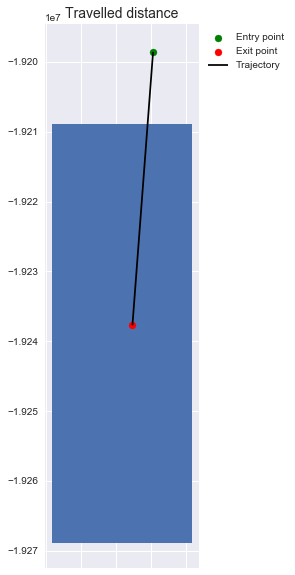

In [14]:
aux = df_train.iloc[60].copy()
pt1 = Point(aux['x_entry'], aux['y_entry'])
pt2 = Point(aux['x_exit'], aux['y_exit'])

fig, ax = plt.subplots()
fig.set_size_inches((10,10))

gpd.GeoSeries(center).plot(ax=ax)
gpd.GeoSeries(pt1).plot(color='green', ax=ax)
gpd.GeoSeries(pt2).plot(color='red', ax=ax)

gpd.GeoSeries(LineString([pt1, pt2])).plot(color='black', ax=ax)

plt.title("Travelled distance", fontsize=14)
# ax.set_yticklabels([])
ax.set_xticklabels([])
ax.legend(['Entry point', 'Exit point', 'Trajectory'], 
          loc='best', bbox_to_anchor=(1, 1))

#### Duration of the trajectory

In [15]:
df_train['duration'] = df_train['time_exit'] - df_train['time_entry']
df_train['duration'] = df_train['duration'].dt.total_seconds() / 60

#### Average speed
average speed using distance computed from the points

In [16]:
df_train['my_vmean'] = df_train['distance'] / df_train['duration']
df_train['my_vmean'].fillna(0, inplace=True)
df_train['my_vmean'].replace(np.inf, 0, inplace=True)

#### Time features
Hour, minute and part of the day

In [17]:
df_train['time_entry_hour'] = df_train['time_entry'].dt.hour
df_train['time_entry_minute'] = df_train['time_entry'].dt.minute

df_train['time_exit_hour'] = df_train['time_exit'].dt.hour
df_train['time_exit_minute'] = df_train['time_exit'].dt.minute

df_train['time_entry_part_day'] = pd.cut(df_train['time_entry'].dt.hour, [0, 4, 8 , 12, 16], labels=['night', 'early morning', 'morning', 'afternoon'], include_lowest=True)
df_train['time_exit_part_day'] = pd.cut(df_train['time_exit'].dt.hour, [0, 4, 8 , 12, 16], labels=['night', 'early morning', 'morning', 'afternoon'], include_lowest=True)

In [18]:
df_train.drop(['time_entry', 'time_exit'], axis=1, inplace=True)

In [19]:
df_train.head()

,hash,trajectory_id,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,is_center_entry,...,point_exit,distance,duration,my_vmean,time_entry_hour,time_entry_minute,time_exit_hour,time_exit_minute,time_entry_part_day,time_exit_part_day
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,0,...,POINT (3750325.814952688 -19136339.92096884),42364.863118,4.016667,10547.268826,7,4,7,8,early morning,early morning
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,0,...,POINT (3744974.687030255 -19319663.69860901),2989.643628,5.133333,582.398109,7,20,7,25,early morning,early morning
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,0,...,POINT (3744815.500158423 -19292841.1535587),725.658561,9.883333,73.422451,7,53,8,3,early morning,early morning
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,0,...,POINT (3744808.820988975 -19290486.59470633),1804.576849,19.550000,92.305721,8,17,8,37,early morning,early morning
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07,0,...,POINT (3744909.008530688 -19285584.9968226),0.000000,0.000000,0.000000,14,38,14,38,afternoon,afternoon


### Distance between the center and entry

In [20]:
x_c = (x_min + x_max) / 2
y_c = (y_min + y_max) / 2

center_point = Point(x_c, y_c)

#### Distance from city limits

In [21]:
df_train['distance_center_entry'] = df_train.apply(lambda x: x['point_entry'].distance(center), axis=1)
df_train['distance_center_exit'] = df_train.apply(lambda x: x['point_exit'].distance(center), axis=1)

In [22]:
df_train['distance_boundary_center_entry'] = df_train.apply(lambda x: x['point_entry'].distance(center.boundary), axis=1)
df_train['distance_boundary_center_exit'] = df_train.apply(lambda x: x['point_exit'].distance(center.boundary), axis=1)

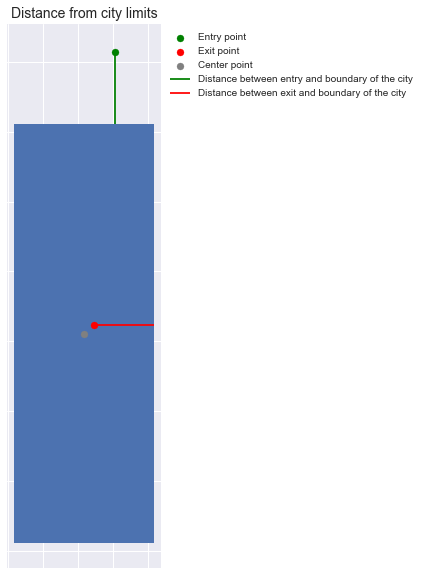

In [23]:
aux = df_train.iloc[60].copy()
pt1 = Point(aux['x_entry'], aux['y_entry'])
pt2 = Point(aux['x_exit'], aux['y_exit'])

fig, ax = plt.subplots()
fig.set_size_inches((10,10))

gpd.GeoSeries(center).plot(ax=ax)
gpd.GeoSeries(pt1).plot(color='green', ax=ax)
gpd.GeoSeries(pt2).plot(color='red', ax=ax)
gpd.GeoSeries(center_point).plot(color='gray', ax=ax)

gpd.GeoSeries(LineString([pt1, nearest_points(pt1, center.boundary)[1]])).plot(color='green', ax=ax)
gpd.GeoSeries(LineString([pt2, nearest_points(pt2, center.boundary)[1]])).plot(color='red', ax=ax)

plt.title("Distance from city limits", fontsize=14)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.legend(['Entry point', 'Exit point', 'Center point',
          'Distance between entry and boundary of the city', 'Distance between exit and boundary of the city'], 
          loc='best', bbox_to_anchor=(1, 1))

#### Distance from the central point

In [24]:
df_train['distance_center_point_entry'] = df_train.apply(lambda x: x['point_entry'].distance(center_point), axis=1)
df_train['distance_center_point_exit'] = df_train.apply(lambda x: x['point_exit'].distance(center_point), axis=1)

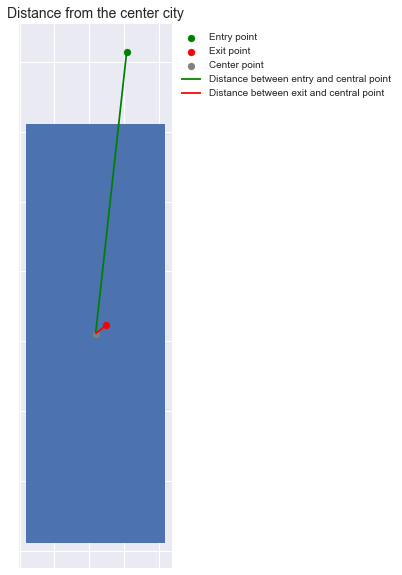

In [25]:
aux = df_train.iloc[60].copy()
pt1 = Point(aux['x_entry'], aux['y_entry'])
pt2 = Point(aux['x_exit'], aux['y_exit'])

fig, ax = plt.subplots()
fig.set_size_inches((10,10))

gpd.GeoSeries(center).plot(ax=ax)
gpd.GeoSeries(pt1).plot(color='green', ax=ax)
gpd.GeoSeries(pt2).plot(color='red', ax=ax)
gpd.GeoSeries(center_point).plot(color='gray', ax=ax)

gpd.GeoSeries(LineString([pt1, center_point])).plot(color='green', ax=ax)
gpd.GeoSeries(LineString([pt2, center_point])).plot(color='red', ax=ax)

plt.title("Distance from the center city", fontsize=14)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.legend(['Entry point', 'Exit point', 'Center point',
          'Distance between entry and central point', 'Distance between exit and central point'], 
          loc='best', bbox_to_anchor=(1, 1))

#### Approach from the center.
Thinking about moving, direction just not enough. Because the person may be walking towards the center or not, all depends on the starting point. Then we calculate the approximation of the center with the distances traveled.

In [26]:
df_train['approach_center_point'] = df_train['distance_center_point_entry'] - df_train['distance_center_point_exit']
df_train['approach_center'] = df_train['distance_boundary_center_entry'] - df_train['distance_boundary_center_exit']

In [27]:
p1 = Point(df_train.iloc[10]['x_entry'], df_train.iloc[10]['y_entry'])
p2 = Point(df_train.iloc[10]['x_exit'], df_train.iloc[10]['y_exit'])

print('Distance from p1 to the center: \t', p1.distance(center.boundary))
print('Distance from p2 to the center: \t', p2.distance(center.boundary))

print('Distance between p1 and p2: \t\t', p1.distance(p2))

print('Approach from the center: \t\t', p1.distance(center.boundary) - p2.distance(center.boundary))

Distance from p1 to the center: 	 104772.796687635
Distance from p2 to the center: 	 28072.47005724907
Distance between p1 and p2: 		 193384.92061495656
Approach from the center: 		 76700.32663038593


#### Delete points

In [28]:
df_train.drop(['point_entry', 'point_exit'], axis=1, inplace=True)

#### Transform Part of the day in binary features 

In [29]:
entry_part_day = pd.get_dummies(df_train['time_entry_part_day'])
entry_part_day.columns = [i + '_entry' for i in entry_part_day.columns]

exit_part_day = pd.get_dummies(df_train['time_exit_part_day'])
exit_part_day.columns = [i + '_exit' for i in exit_part_day.columns]

df_train = pd.concat([df_train, entry_part_day, exit_part_day], axis=1)
df_train.drop(['time_entry_part_day', 'time_exit_part_day'], axis=1, inplace=True)

In [30]:
df_train.head()

,hash,trajectory_id,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,is_center_entry,...,approach_center_point,approach_center,night_entry,early morning_entry,morning_entry,afternoon_entry,night_exit,early morning_exit,morning_exit,afternoon_exit
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,0,...,42152.393092,42356.993415,0,1,0,0,0,1,0,0
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,0,...,2952.932615,2909.859939,0,1,0,0,0,1,0,0
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,0,...,679.206396,689.590573,0,1,0,0,0,1,0,0
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,0,...,1703.405368,1722.441948,0,1,0,0,0,1,0,0
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07,0,...,0.000000,0.000000,0,0,0,1,0,0,0,1


In [31]:
df_train.columns.to_list()

['hash',
 'trajectory_id',
 'vmax',
 'vmin',
 'vmean',
 'x_entry',
 'y_entry',
 'x_exit',
 'y_exit',
 'is_center_entry',
 'is_center_exit',
 'distance',
 'duration',
 'my_vmean',
 'time_entry_hour',
 'time_entry_minute',
 'time_exit_hour',
 'time_exit_minute',
 'distance_center_entry',
 'distance_center_exit',
 'distance_boundary_center_entry',
 'distance_boundary_center_exit',
 'distance_center_point_entry',
 'distance_center_point_exit',
 'approach_center_point',
 'approach_center',
 'night_entry',
 'early morning_entry',
 'morning_entry',
 'afternoon_entry',
 'night_exit',
 'early morning_exit',
 'morning_exit',
 'afternoon_exit']

### Change the grain and use trajectories as features
This is one of main approaches. In the current dataset, the hash has many trajectories, but the prediction is made for the last one (after 15 P.M).
So, let's use the trajectories to create a sequence where the priority is the last. This is, we will sort the trajectories by the last ones.

The number *k* of trajectories used will be 20 (all), but can be changed.

This transformation consume the most time of the proccess. There are approximately 135 thousand hashes and a total of 815 thousand of trajectories. Then, I recommend execute this on terminal through the code Python for execute more fast.

#### Create aggregate features during the transformation
During the transformation of grain is created aggregate features. The trajectories become features, but before, the set of features are used for compute general information, searching find caracteristics of jorney.

Features:
* Average distance
* Average duration
* Average velocity (my_vmean, previously created feature)
* Distance estimated (Average velocity * Average duration)
* Number of trajectories

In [32]:
k = 20
rows = []
size = len(df_train['hash'].unique())

In [33]:
count = 1
for h in df_train['hash'].unique():
    if count % 500 == 0:
        print('{}/{}'.format(count, size))

    df_user = df_train[df_train['hash'] == h]
    trajectory_id = df_user.iloc[-1]['trajectory_id']
    df_user = df_user.drop(['hash', 'trajectory_id'], axis=1)

    last_trajectory = df_user.iloc[[-1]].reset_index(drop=True)

    target = last_trajectory['is_center_exit']
    
    ### Remove a posteriori information from last trajectory, because at the moment of prediction (in test set, for example), 
    ### there is no such data
    last_trajectory = last_trajectory.drop(
        [
            'vmax', 'vmin', 'vmean', 'x_exit', 'y_exit', 'distance', 'is_center_exit', 'my_vmean',
            'distance_center_exit', 'distance_boundary_center_exit', 'distance_center_point_exit',
            'approach_center_point', 'approach_center'
        ], axis=1)
    last_trajectory.columns = last_trajectory.columns.map(lambda x: str(x) + '_last')

    # CREATE AGGREGATE FEATURES
    
    last_trajectory['distance_mean'] = df_user.iloc[:-1]['distance'].mean()
    last_trajectory['duration_mean'] = df_user.iloc[:-1]['duration'].mean()
    last_trajectory['my_vmean_mean'] = df_user.iloc[:-1]['my_vmean'].mean()
    last_trajectory['distance_estimated'] = last_trajectory['my_vmean_mean'] * last_trajectory['duration_mean']
    last_trajectory['amount_trajectories'] = df_user.shape[0]

    # FOR FEATURES IN DESCENDING ORDER

    trajectories = [last_trajectory]

    amount_trajectories = df_user.shape[0] - 1 - 1   # 1 by the last element and 1 by consider the zero
    
    # SELECT THE k LAST ONES TRAJECTORIES
    j = k - 1
    for i in range(amount_trajectories, max(amount_trajectories - k + 1, -1), -1):
        aux = df_user.iloc[[i]]
        aux.columns = aux.columns.map(lambda x: str(x) + '_' + str(j))
        aux.reset_index(drop=True, inplace=True)
        trajectories.append(aux)
        j -= 1

    row = pd.concat(trajectories, axis=1, ignore_index=False)

    row['target'] = target
    row['trajectory_id'] = trajectory_id
    rows.append(row)

    count += 1

500/134063
1000/134063
1500/134063
2000/134063
2500/134063
3000/134063
3500/134063
4000/134063
4500/134063
5000/134063
5500/134063
6000/134063
6500/134063
7000/134063
7500/134063
8000/134063
8500/134063
9000/134063
9500/134063
10000/134063
10500/134063
11000/134063
11500/134063
12000/134063
12500/134063
13000/134063
13500/134063
14000/134063
14500/134063
15000/134063
15500/134063
16000/134063
16500/134063
17000/134063
17500/134063
18000/134063
18500/134063
19000/134063
19500/134063
20000/134063
20500/134063
21000/134063
21500/134063
22000/134063
22500/134063
23000/134063
23500/134063
24000/134063
24500/134063
25000/134063
25500/134063
26000/134063
26500/134063
27000/134063
27500/134063
28000/134063
28500/134063
29000/134063
29500/134063
30000/134063
30500/134063
31000/134063
31500/134063
32000/134063
32500/134063
33000/134063
33500/134063
34000/134063
34500/134063
35000/134063
35500/134063
36000/134063
36500/134063
37000/134063
37500/134063
38000/134063
38500/134063
39000/134063
39500/

In [34]:
dataset = pd.concat(rows, sort=False)

#### Clear the data

In [35]:
dataset.fillna(0, inplace=True)
dataset.reset_index(drop=True, inplace=True)
dataset.head()

,x_entry_last,y_entry_last,is_center_entry_last,duration_last,time_entry_hour_last,time_entry_minute_last,time_exit_hour_last,time_exit_minute_last,distance_center_entry_last,distance_boundary_center_entry_last,...,approach_center_point_1,approach_center_1,night_entry_1,early morning_entry_1,morning_entry_1,afternoon_entry_1,night_exit_1,early morning_exit_1,morning_exit_1,afternoon_exit_1
0,3.744945e+06,-1.928183e+07,0,16.033333,15,2,15,18,14234.591990,14234.591990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.749088e+06,-1.926605e+07,0,29.266667,15,0,15,29,1813.564585,1813.564585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.758738e+06,-1.937594e+07,0,45.266667,14,34,15,19,107034.585072,107034.585072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.767866e+06,-1.917797e+07,0,0.000000,15,28,15,28,30940.232815,30940.232815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.747641e+06,-1.922695e+07,0,0.000000,15,8,15,8,3260.717965,3260.717965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Save the data
After generating the dataset, you can save it and explore the modeling phase. Saving the dataset you avoid the create the data again.

In [36]:
dataset.to_csv('data/processed/train_dataset_complete.csv', index=False)

### Separate train and test set
Now, each instance (row) is a hash. With this grain we can separate the train and test sets with common split.

It is also possible to divide the sets before the transformation, but it is necessary separate by the hashes (attribute) and not by the lines.

In [37]:
train, test = train_test_split(dataset, test_size=0.3)

### Separate features and targets

In [38]:
X_train = train.drop(['target', 'trajectory_id'], axis=1)
X_test = test.drop(['target', 'trajectory_id'], axis=1)

y_train = train.loc[:, 'target'].copy()
y_test = test.loc[:, 'target'].copy()

### Modeling

In [39]:
forest = RandomForestClassifier()

In [40]:
forest.fit(X_train, y_train)

C:\Users\Milton\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
pred = forest.predict(X_test)

In [42]:
f1_score(y_test, pred)

0.8686045967326687

#### XGBoost (Extreme Gradient Boosting)

In [43]:
# import
from xgboost.sklearn import XGBClassifier

In [44]:
model = XGBClassifier(n_jobs=-1, n_estimators=1000, learning_rate=0.05, max_depth=6, 
                      colsample_bytree=0.9, subsample=0.8, min_child_weight=4, reg_alpha=0.005)
model.fit(X_train, y_train)

pred = model.predict(X_test)
f1_score(y_test, pred)

0.8887227181380568